In [2]:
import logging 
import time
import os


import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf 

import tensorflow_text as text

/Users/sj/Desktop/PT-EN-Transformer/transformer_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Downloading and Preparing DataSet from tensorflow's datasets


In [3]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en',
                               with_info=True,
                               as_supervised=True) 

train_examples,val_example = examples['train'],examples['validation']

In [4]:
for pt_example, en_example in train_examples.batch(3).take(1):
    print('>example in porturges')
    for pt in pt_example.numpy():
        print(pt.decode('utf-8'))
    print()
    print('>example in English ')
    for pt in en_example.numpy():
        print(pt.decode('utf-8'))
    print()
    
    

>example in porturges
e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

>example in English 
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .



2025-07-28 03:09:49.743064: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-07-28 03:09:49.748252: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-07-28 03:09:49.749123: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Setup tokenizer

In [5]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

'./ted_hrlr_translate_pt_en_converter_extracted'

In [6]:

try:
    tokenizers = tf.saved_model.load(model_name)
    print("Model loaded successfully!")
except OSError as e:
    print(f"Error loading model: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


Model loaded successfully!


In [7]:
lengths = []
for pt_example,en_example in train_examples.batch(1024):
    pt_token = tokenizers.pt.tokenize(pt_example)
    lengths.append(pt_token.row_lengths())

    en_token = tokenizers.en.tokenize(en_example)
    lengths.append(en_token.row_lengths())
    print('.',end = '', flush=True)

...................................................

2025-07-28 03:09:53.388052: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


#SetUp the data pipeline with tf.data

##The following fun takes batches of text as input, and convert them to a format suitable for training.



In [8]:

MAX_TOKOENS = 128

def prepare_batch(pt_examples, en_examples):
    pt_tokens = tokenizers.pt.tokenize(pt_examples) # output is ragged tensor
    pt_tokens = pt_tokens[:, :MAX_TOKOENS]          # Trim to max length
    pt_tokens = pt_tokens.to_tensor()               # Convert to 0-padded dense tensor   
   

    en_tokens = tokenizers.en.tokenize(en_examples)
    en_tokens = en_tokens[:, :(MAX_TOKOENS+1)]     
    en_inputs = en_tokens[:, :-1].to_tensor()  # Drop the end token 
    en_labels = en_tokens[:, 1:].to_tensor()   
    
    
    return (pt_tokens, en_inputs), en_labels

###The function  below converts the dataset of text examples into data of batches for training 

In [9]:
Buffer_SIZE = 20000
Batch_SIZE = 64

def make_batches(ds) :
    return (
        ds
        .shuffle(Buffer_SIZE)
        .batch(Batch_SIZE)
        .map(prepare_batch, tf.data.AUTOTUNE)
        .prefetch(buffer_size = tf.data.AUTOTUNE)
    )

# Test Dataset

In [10]:

train_batches = make_batches(train_examples)
val_batches = make_batches(val_example)

In [11]:
for(pt , en ), en_labels in train_batches.take(1):
    break 
print('pt shape:', pt.shape)
print('en shape:', en.shape)
print('en labels shape:', en_labels.shape)
print('pt tokens:', pt[0])
print('en inputs:', en[0])
print('en labels:', en_labels[0])
    

pt shape: (64, 100)
en shape: (64, 104)
en labels shape: (64, 104)
pt tokens: tf.Tensor(
[   2  140   14   88  371  106  102   40  118  103 5865   14  204  514
   54   84  127 3732   16    3    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0], shape=(100,), dtype=int64)
en inputs: tf.Tensor(
[   2  157   13   96   84   50    9   56  170  414   73   91   77   71
 3155 3713   13   82   78  149   15    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0   

In [12]:
def positional_encoding( length ,depth ):
    depth = depth/2;
    
    positions = np.arange(length)[:, np.newaxis] 
    depths = np.arange(depth)[np.newaxis, :]/depth 
    
    angle_rates = 1 / (10000**depths)
    angle_rads = positions * angle_rates
    
    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1
    )
    return tf. cast(pos_encoding, dtype=tf.float32)

positional encoding shape: (2048, 512)


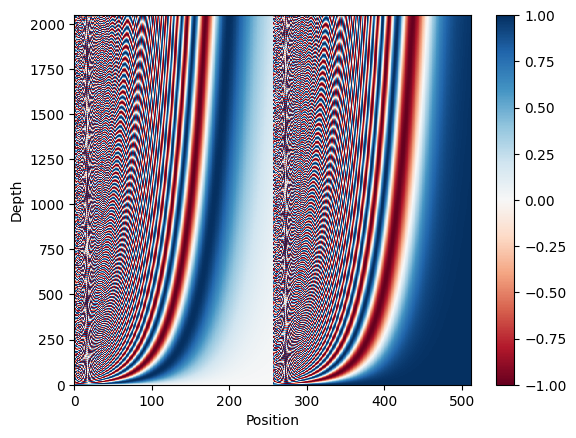

In [13]:
pos_encoding = positional_encoding(length=2048, depth = 512)

print('positional encoding shape:', pos_encoding.shape)

# plot
plt.pcolormesh(pos_encoding.numpy(), cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

In [14]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model,mask_zero=True)              
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)
    
    def compute_mask(self,*args,**kwargs):
        return self.embedding.compute_mask(*args, **kwargs)
    
    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        
        x *= tf.math.sqrt(tf.cast(self.d_model, dtype=tf.float32))
        x= x+ self.pos_encoding[tf.newaxis,:length, :]
        return x 

In [15]:
embed_pt = PositionalEmbedding(vocab_size=tokenizers.pt.get_vocab_size().numpy(), d_model=512)
embed_en = PositionalEmbedding(vocab_size=tokenizers.en.get_vocab_size().numpy(), d_model=512)

pt_embed = embed_pt(pt);
en_embed = embed_en(en);

In [16]:
en_embed._keras_mask

<tf.Tensor: shape=(64, 104), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

In [17]:
class BaseAttenmtion(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()
        

#Defining Cross Attention Layer Structure

In [18]:
class CrossAttention(BaseAttenmtion):
    def call(self,x,context):
        attn_output,attn_scores = self.mha(
            query=x,
            key=context,
            value=context,
            return_attention_scores=True
            )
        self.lst_attn_score = attn_scores
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [19]:
sample_ca  = CrossAttention(num_heads=2, key_dim=512)

print(pt_embed.shape)
print(en_embed.shape)
print(sample_ca(pt_embed, en_embed).shape)


(64, 100, 512)
(64, 104, 512)
(64, 100, 512)


#Defining Global Attention Layer Structure

In [20]:
class GlobalAttention(BaseAttenmtion):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            key=x,
            value=x
        )
       
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [21]:
sample_ga = GlobalAttention(num_heads=2, key_dim=512)

print(pt_embed.shape)
print(sample_ga(pt_embed).shape)

(64, 100, 512)
(64, 100, 512)


#Defining Casual Self-Attention Layer Structure

In [27]:
class CasualSelfAttention(BaseAttenmtion):
    def call(self,x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x,
            use_causal_mask=True
        )
        x=self.add([x,attn_output])
        x=self.layernorm(x)
        return x

In [28]:
sample_csa=CasualSelfAttention(num_heads=2,key_dim=512)
print(en_embed)
print(sample_csa(en_embed).shape)

tf.Tensor(
[[[ 0.8807087   0.73906666 -0.22418186 ...  0.79418904  1.855387
    1.408826  ]
  [ 1.8543559   1.6004266   1.8432925  ...  2.1087213   1.7402297
    0.03622526]
  [ 2.0050108   1.1144884   1.775018   ...  1.9779094   1.3185499
    2.117654  ]
  ...
  [-0.19530717 -0.3419706   0.42140725 ...  0.4698801   0.42586893
    0.3175428 ]
  [ 0.34749383 -1.1452892   1.2999227  ...  0.46987885  0.42586774
    0.31754172]
  [-0.02434433 -1.2216005   1.6780308  ...  0.4698776   0.42586654
    0.31754065]]

 [[ 0.8807087   0.73906666 -0.22418186 ...  0.79418904  1.855387
    1.408826  ]
  [-0.23790944  1.5039134   0.6579536  ...  1.4334188   1.7411306
   -0.11681318]
  [-0.17008299  1.6184719   0.81413615 ...  1.4334188   1.7411306
   -0.11681318]
  ...
  [-0.19530717 -0.3419706   0.42140725 ...  0.4698801   0.42586893
    0.3175428 ]
  [ 0.34749383 -1.1452892   1.2999227  ...  0.46987885  0.42586774
    0.31754172]
  [-0.02434433 -1.2216005   1.6780308  ...  0.4698776   0.42586654
   

# Defining FeedForward Neural Network Structure

In [30]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self,d_model,dff,dropout_rate = 0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff,activation='relu'),
            tf.keras.layers.Dense(d_model),
            tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.ADD()
        self.layer_norm = tf.keras.layers.LayerNormalization()
        
    def call(self,x):
        x=self.add([x,self.seq(x)])
        x=self.layer_norm(x)
        return x

# Defining Encoder Layer 

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        
        self.self_attention = GlobalAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)
        
        self.ffn = FeedForward(d_model=d_model, dff=dff)
    
    
    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

In [ ]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=2, dff=2048)

print(pt_embed.shape)
print(sample_encoder_layer(pt_embed).shape)

# Defining Encoder